CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [45]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some parameters

In [46]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'cnn',
    "DS_INFO": 'complete',
    "resample": True,
    "neg_class": ['ship'],
    "NUM_EPOCHS": 20,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (128, 128, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [47]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['esophagitis' 'normal-pylorus' 'ulcerative-colitis' 'normal-cecum'
 'normal-z-line' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps']

esophagitis       : 1000
normal-pylorus    : 1000
ulcerative-colitis: 1000
normal-cecum      : 1000
normal-z-line     : 1000
polyps            : 1000
dyed-resection-margins: 1000
dyed-lifted-polyps: 1000

Total number of images: 8000, in 8 classes
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[7 1 5 7 7 1 7 6 1 2]
[6 6 3 5 1 2 1 6 0 4]
[5 6 3 4 4 2 5 0 3 5]
[5 6 1 4 1 0 0 2 2 3]
[6 4 2 1 2 1 2 7 3 6]
[2 6 0 5 7 0 6 1 7 5]
[5 2 5 4 3 2 7 2 1 6]
[4 6 3 2 2 6 7 1 1 5]
[3 2 0 1 1 4 5 4 7 1]
[1 6 2 6 1 6 2 2 3 6]

Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


## Training
### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [48]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

Create the model

In [49]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config["IMG_SIZE"]))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(params["NUM_CLASSES"], activation='softmax'))

In [50]:
if config["verbosity"] > 0:
    cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)       

Compile and train the model

In [51]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(model_name), update_freq='batch')]

In [52]:
history = cnn_model.fit(
        train_ds,
         steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 87 steps, validate for 18 steps
Epoch 1/20
87/87 [==============================] - 48s 555ms/step - loss: 1.5117 - accuracy: 0.4531 - val_loss: 4.5818 - val_accuracy: 0.2622
Epoch 2/20
87/87 [==============================] - 3s 32ms/step - loss: 1.3438 - accuracy: 0.4610 - val_loss: 1.6524 - val_accuracy: 0.4115
Epoch 3/20
87/87 [==============================] - 4s 42ms/step - loss: 1.2108 - accuracy: 0.5181 - val_loss: 2.3681 - val_accuracy: 0.3993
Epoch 4/20
87/87 [==============================] - 3s 32ms/step - loss: 1.2234 - accuracy: 0.5043 - val_loss: 1.1836 - val_accuracy: 0.4714
Epoch 5/20
87/87 [==============================] - 3s 32ms/step - loss: 1.2491 - accuracy: 0.4937 - val_loss: 1.4786 - val_accuracy: 0.5755
Epoch 6/20
87/87 [==============================] - 3s 32ms/step - loss: 1.2236 - accuracy: 0.5120 - val_loss: 3.1069 - val_accuracy: 0.4019
Epoch 7/20
87/87 [==============================] - 3s 32ms/step - loss: 1.1540 - accuracy: 0.5095 - val_loss:

In [53]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [54]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

18/18 - 52s - loss: 0.7846 - accuracy: 0.6536


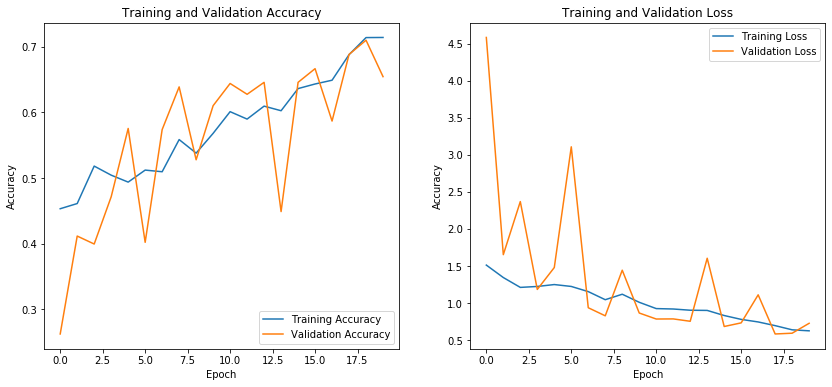

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [56]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 esophagitis
0.0002 normal-pylorus
0.9653 ulcerative-colitis
0.0000 normal-cecum
0.0000 normal-z-line
0.0345 polyps
0.0000 dyed-resection-margins
0.0000 dyed-lifted-polyps

Label: ulcerative-colitis
Predicton: ulcerative-colitis


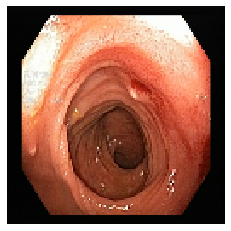

In [57]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [58]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label                     pred                     
---  ------------------------- -------------------------
  0  ulcerative-colitis        ulcerative-colitis       
  1  esophagitis               esophagitis              
  2  normal-cecum              polyps                     Wrong
  3  ulcerative-colitis        ulcerative-colitis       
  4  normal-z-line             normal-z-line            
  5  esophagitis               esophagitis              
  6  dyed-lifted-polyps        dyed-lifted-polyps       
  7  normal-pylorus            normal-z-line              Wrong
  8  dyed-lifted-polyps        dyed-lifted-polyps       
  9  esophagitis               esophagitis              
 10  dyed-resection-margins    dyed-lifted-polyps         Wrong
 11  normal-pylorus            normal-pylorus           
 12  ulcerative-colitis        polyps                     Wrong
 13  polyps                    polyps                   
 14  polyps                    polyps                   
 15